In [46]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import xarray as xr
import metpy.calc as mpcalc
from utils import *
import sys
import matplotlib.gridspec as gridspec
from datetime import datetime

In [4]:
dset = xr.open_mfdataset(input_files, concat_dim='ens_member').squeeze()
dset = dset.metpy.parse_cf()
time = pd.to_datetime(dset['time'].values)
# Array needed for the box plot
pos = np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

In [ ]:
cities=['Milano','Roma','Palermo']
data={}
for city in cities:
    lon, lat = get_city_coordinates(city)
    dset_city =  dset.sel(lon=lon, lat=lat, method='nearest').interpolate_na(dim='time')
    # Recover units which somehow are deleted by interpolate_na,
    # no idea why....
    dset_city['t'].attrs['units'] = 'K'
    dset_city['t'].metpy.convert_units('degC')
    dset_city['2t'].attrs['units'] = 'K'
    dset_city['2t'].metpy.convert_units('degC')
    data[city] = dset_city

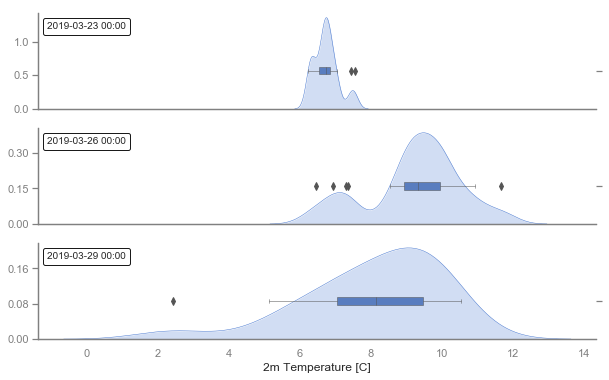

In [100]:
city_to_plot="Milano"
var_to_plot='2t'
myDates= ["2019-03-23 00:00", "2019-03-26 00:00", "2019-03-29 00:00"]

fig = plt.figure(1, figsize=(10, 6))

nrows=np.shape(myDates)[0]
rows=np.arange(start=0, stop=nrows, step=1)
gridspec.GridSpec(nrows,1)

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context(rc={"lines.linewidth": 0.5})
plt.rc_context({'axes.edgecolor':'grey', 'xtick.color':'grey', 'ytick.color':'grey'})
plt.title("GEFS PDF forecast for "+city_to_plot+" | Run "+(time[0]-np.timedelta64(6,'h')).strftime('%Y%m%d %H UTC'))

for row in rows:
    ds = data[city_to_plot][var_to_plot].sel(time=myDates[row], method='nearest')
    if row == rows[0]:
        ax1=plt.subplot2grid((nrows,1), (row,0))
    else: 
        plt.subplot2grid((nrows,1), (row,0), sharex=ax1)
    
    ax2 = sns.distplot(ds, hist=False, kde_kws={"shade":True})
    
    ax3 = ax2.twinx()
    ax3.get_xaxis().set_visible(False)
    sns.boxplot(x=ds, ax=ax3)
    sns.despine()
    ax3.set(ylim=(-4, 6))
    at = AnchoredText(myDates[row], prop=dict(size=10), frameon=True,loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
    if row != rows[-1]:
        ax2.get_xaxis().set_visible(False)
    else: 
        ax2.get_xaxis().set_visible(True)
        ax2.set_xlabel('2m Temperature [C]')

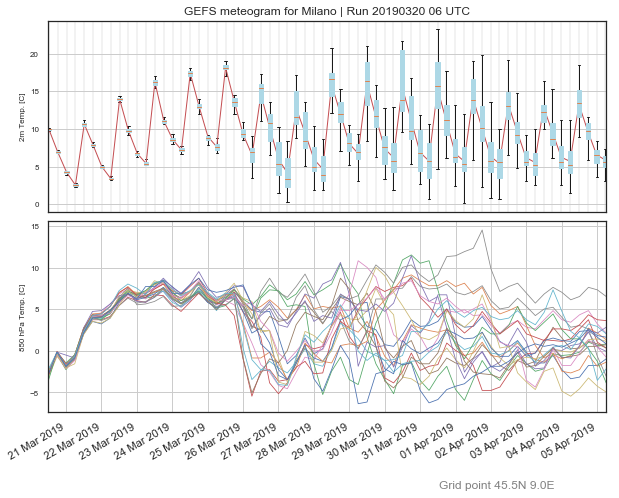

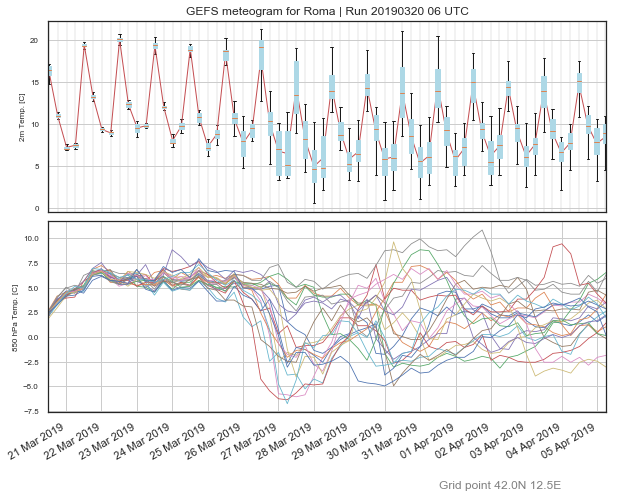

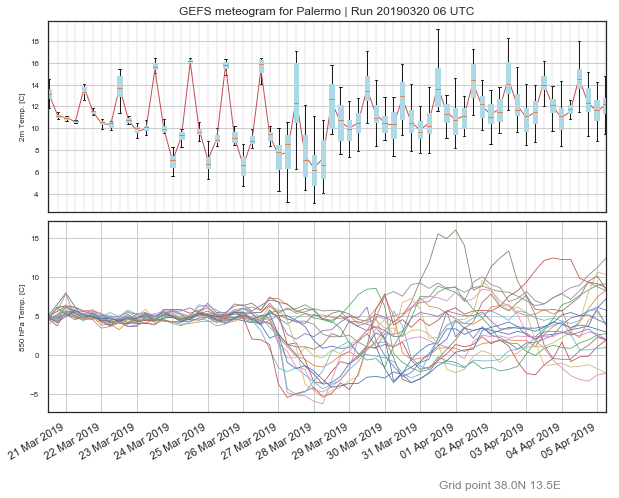

In [94]:
nrows=2
ncols=1
sns.set(style="white")

for city_to_plot in cities:
    fig = plt.figure(1, figsize=(10,8))
    ax1=plt.subplot2grid((nrows,ncols), (0,0))
    ax1.set_title("GEFS meteogram for "+city_to_plot+" | Run "+(time[0]-np.timedelta64(6,'h')).strftime('%Y%m%d %H UTC'))
    
    bplot=ax1.boxplot(data[city_to_plot]['2t'].T, patch_artist=True,
                      showfliers=False, positions=pos, widths=3)
    for box in bplot['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')

    ax1.plot(pos, data[city_to_plot]['2t'].mean(dim='ens_member'), 'r-', linewidth=1)
    ax1.set_ylabel("2m Temp. [C]",fontsize=8)
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(True, color='gray', linewidth=0.2)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax1.tick_params(axis='x', which='both', bottom=False)

    ax4=plt.subplot2grid((nrows,ncols), (1,0))
    ax4.plot(time, data[city_to_plot]['t'].T, '-',linewidth=0.8)
    ax4.set_xlim(time[0],time[-1])
    ax4.set_ylabel("850 hPa Temp. [C]",fontsize=8)
    ax4.tick_params(axis='y', which='major', labelsize=8)
    ax4.yaxis.grid(True)
    ax4.xaxis.grid(True)
    ax4.xaxis.set_major_locator(mdates.DayLocator())
    ax4.xaxis.set_major_formatter(DateFormatter('%d %b %Y'))

    ax4.annotate('Grid point %3.1fN %3.1fE' % (data[city_to_plot].lat, data[city_to_plot].lon),
                 xy=(0.7, -0.4), xycoords='axes fraction', color="gray")

    fig.subplots_adjust(hspace=0.05)
    fig.autofmt_xdate()
    #plt.savefig('meteogram_cold.png',dpi=120,bbox_inches='tight')
    plt.show()